## Snakes and Ladders - as a Markov process

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), os.pardir)))

from dataclasses import dataclass
import matplotlib.pyplot as plt
import heapq

from rl.distributions import Categorical, Constant, FiniteDistribution
from rl.markov_process import FiniteMarkovProcess, NonTerminal

from snakes_and_ladders import generate_ladder_connections, generate_snake_connections

In [2]:
@dataclass(frozen=True)
class State:
    """
    Represents the state of the player on the Snakes and Ladders board.

    The state is defined solely by the player's position. It is frozen
    to ensure immutability, which is necessary when using it as a key
    in a dictionary (e.g., in the transition map).

    Attributes:
        position: The square number the player is currently on (1 to num_squares).
    """

    position: int


class SnakesAndLadders(FiniteMarkovProcess[State]):
    """
    Models the game of Snakes and Ladders as a Finite Markov Process (FMP).

    The game state is the player's position on the board. The process
    is defined by the transition probabilities after a single die roll.

    Attributes:
        num_rolls (int): The maximum value of the die (e.g., 6 for a standard die).
        num_squares (int): The total number of squares on the board (e.g., 100).
        snakes (dict[int, int]): Mapping of snake heads (source) to tails (destination).
        ladders (dict[int, int]): Mapping of ladder bases (source) to tops (destination).
    """

    num_rolls: int
    num_squares: int
    snakes: dict[int, int]
    ladders: dict[int, int]

    def __init__(
        self,
        snakes: dict[int, int],
        ladders: dict[int, int],
        num_rolls: int = 6,
        num_squares: int = 100,
    ):
        self.num_rolls = num_rolls
        self.num_squares = num_squares
        self.snakes = snakes
        self.ladders = ladders

        super().__init__(transition_map=self.compute_transitions())

    def compute_transitions(self) -> dict[State, FiniteDistribution[State]]:
        """
        Computes the transition probabilities for all non-terminal states.

        The transition map links a current State to a distribution over
        possible next States after one die roll.

        A state is considered terminal (and skipped) if:
        1. It is the end square (num_squares).
        2. It is the head of a snake or the base of a ladder, as the player
           immediately moves from there to the destination.

        Returns:
            A dictionary where keys are non-terminal State objects and values
            are Categorical distributions over the possible next State objects.
        """
        transitions: dict[State, FiniteDistribution[State]] = {}

        for current_position in range(1, self.num_squares + 1):
            if (
                current_position in self.snakes
                or current_position in self.ladders
                or current_position == self.num_squares
            ):
                continue

            tmp_dist: dict[State, float] = dict()
            current_state = State(position=current_position)

            for direction in range(1, self.num_rolls + 1):
                next_position = current_position + direction

                # the player needs to roll the exact
                # number in order to reach 10
                if next_position > self.num_squares:
                    next_position = current_position

                # travel down the snake or the ladder
                next_position = self.snakes.get(next_position, next_position)
                next_position = self.ladders.get(next_position, next_position)

                # assign a value of 1
                # (the Categorical init method will normalize it)
                tmp_dist[State(position=next_position)] = (
                    tmp_dist.get(State(position=next_position), 0.0) + 1.0
                )

            transitions[current_state] = Categorical(tmp_dist)

        return transitions

In [8]:
ROLLS = 3
SQUARES = 20
N_LADDERS = 4
N_SNAKES = 6

# generate random snake/ladder connections for the game
snakes = generate_snake_connections(n_snakes=N_SNAKES, n_squares=SQUARES)
ladders = generate_ladder_connections(n_ladders=N_LADDERS, n_squares=SQUARES)

game = SnakesAndLadders(
    ladders=ladders,
    snakes=snakes,
    num_rolls=ROLLS,
    num_squares=SQUARES,
)

In [9]:
# print the transition probabilities (for debugging purposes)
# set SQUARES to a small number
print(game)

From State State(position=1):
	To State State(position=2) with Probability 0.333
	To State State(position=14) with Probability 0.667
From State State(position=2):
	To State State(position=14) with Probability 0.667
	To State State(position=5) with Probability 0.333
From State State(position=5):
	To State State(position=2) with Probability 0.333
	To State State(position=18) with Probability 0.333
	To State State(position=8) with Probability 0.333
From State State(position=8):
	To State State(position=9) with Probability 0.667
	To State State(position=10) with Probability 0.333
From State State(position=9):
	To State State(position=10) with Probability 0.333
	To State State(position=9) with Probability 0.333
	To State State(position=18) with Probability 0.333
From State State(position=10):
	To State State(position=9) with Probability 0.333
	To State State(position=18) with Probability 0.333
	To State State(position=5) with Probability 0.333
From State State(position=14):
	To State State(

In [10]:
# to find the distribution of "time" (as measured by the number of
# rolls of the dice) to finish the game, we generate 1000 sampling
# traces and then count the length of each trace (as it terminates)
# on a TerminalState. Use this list of times to generate the histogram.
traces = [
    sum(
        1
        for _ in game.simulate(
            start_state_distribution=Constant(NonTerminal(State(position=1)))
        )
    )
    for _ in range(1_000)
]

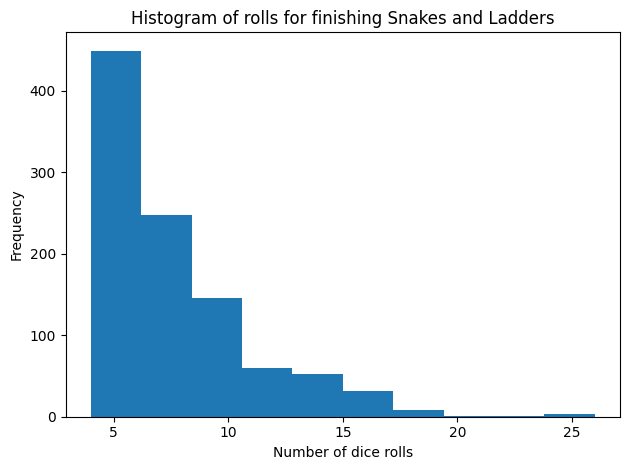

In [11]:
plt.hist(traces)

plt.title("Histogram of rolls for finishing Snakes and Ladders")
plt.xlabel("Number of dice rolls")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [12]:
# in order to find the stationary distribution, use
# the method developed in FiniteMarkovProcess class
stationary_distribution = game.compute_stationary_distribution()
top_k_states = heapq.nlargest(5, stationary_distribution, key=lambda x: x[1])

for state, prob in top_k_states:
    print(f"{state=}: {prob=:.3f}")

state=State(position=19): prob=0.858
state=State(position=18): prob=0.060
state=State(position=9): prob=0.028
state=State(position=10): prob=0.019
state=State(position=5): prob=0.012


## Conclusion
In the long run, the player will get stuck on the 18th or 19th squares as they need only a dice roll of 1 or 2 to end the game.